# Feature selection with L1 Regularization

* Consider a supervised learning setting where you have data $\mathcal{D} = \{(X, Y)\}$, where $X \in \mathbb{R}^{NXD}$. $N$  - num of datapoints and $D$ - num of features. Many of the features may be irrelevant for the task at hand.
* Typically when there are more features than samples, ie. $D >> N$, a simple linear regression model is prone to overfit.
* As we have seen before, regularization is one of the tools in our toolbox to combat overfitting. Here we will see how they do that and how $L1$ regularization can be used for feature selection.

## Tasks

1. Load the data "cancer_reg.csv" data.
2. Preprocess your data particularly making sure there are no nan values.
3. Since we want to study overfitting and how to solve it, we are going to add correlated features to our data to increase the number of features. These new features are usless, we will see how to remove them with $L1$ regularization. We will take only small portion of the data for training (It could be 20% for training). This will make our model overfit, later on we will regularize the model to solve the overfitting.
4. Define your linear regression model with and without regularization ($L1$ and $L2$)
5. Train and test your linear regression models (without regularization) till it overfits the data. Plot the learning curves for training and testing (You may ignore loss values for the first 10 epochs)
6. Train and test again with $L1$ regularization and visually inspect the effects. Plot the weights for each model (using matplotlib stem plot). Do you see any difference between them?
7. In the case of the $L1$ **(Lasso) **regularization, set a small threshold and remove all features of the data corresponding to the weights with values below this threshold. Train a new model with remaining features (with or without regularization)
8. Train and test again with $L2$ regularization **(Ridge)** and visually inspect the effects. Plot the weights for each model (using matplotlib stem plot). Do you see any difference between them?
9. Train and test again with $L1$ + $L2$ regularization **(Elastic Net)** and visually inspect the effects. Plot the weights for each model (using matplotlib stem plot). Do you see any difference between them?


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Load the data "cancer_reg.csv" data from here. A slightly modified copy will be shared with you on workplace. Target is labeled "TARGET_deathRate".

#Dataset Class:

It is always recommended to create a seperate class to prepare the data. Usually we use the Dataset class for:


1.   Downloading the data, if needed.
2.   Preprocessing the data.
3.   Spliting the data.




In [ ]:
class Dataset:
  def __init__(self, path, test_size=0.85):
    self.test_size = test_size
    if path==None:
        self.train_inputs = []
        self.test_inputs = []
        self.train_targets = []
        self.test_targets = []
    else:
        self.initialize(path)
    
  def initialize(self, path):
    data = pd.read_csv(path,  encoding='latin-1')
    #Fill all the NAN values with the mean
    for col in data.columns:
      if data[col].isna().sum()!=0:
        data[col][data[col].isna()] = data[col].mean()
        
    data = data.drop(['Geography', 'binnedInc'], axis=1)
    
    target = data["TARGET_deathRate"].values
    inputs = data.drop("TARGET_deathRate", axis=1)


    #here we add more features
    for col in inputs.columns:
      for i in range(2,10):
        new_col = f'{col}_{i}' 
        inputs[new_col] =  inputs[col]**i

    inputs = inputs.values
    inputs = inputs/inputs.max(axis=0)
    self.target = target
    self.inputs = inputs
    
    #Shuffle before splitting the data
    indices = np.arange(len(self.target))
    np.random.shuffle(indices)
    test_num_points = int(self.test_size * len(indices))
    test_indices = indices[:test_num_points]
    train_indices = indices[test_num_points:]

    self.train_inputs = self.inputs[train_indices]
    self.test_inputs = self.inputs[test_indices]
    self.train_targets = self.target[train_indices]
    self.test_targets = self.target[test_indices]
  


    

In [ ]:
dataset = Dataset("cancer_reg.csv") #"cancer-mortality-rate.csv

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [ ]:
print("train inputs shape: ",dataset.train_inputs.shape)
print("test inputs shape: ",dataset.test_inputs.shape)

train inputs shape:  (458, 279)
test inputs shape:  (2589, 279)


# Linear Regression With Regularization:

In [ ]:
class LinearRegressionModel:
  def __init__(self, dataset, l1 = 0.0, l2 = 0.0, lr = 0.001, epochs=10000):
    self.dataset = dataset
    self.l1 = l1
    self.l2 = l2
    self.learning_rate = lr
    self.epochs = epochs
    self.theta = np.random.randn(dataset.train_inputs.shape[1]+1)

  def add_one(self, x):
    X_new=np.hstack([np.ones((x.shape[0], 1)), x])
    return X_new

  def predict(self, x):
    y_pred=x@self.theta
    return y_pred

  def compute_mse_loss(self, y_true, y_pred):
    loss=np.square(np.subtract(y_true,y_pred)).mean()
    return loss

  def plot_loss_and_params(self, train_losses, test_losses):

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
    ax1.plot(train_losses[:], label="train-loss", color='blue')
    ax1.plot(test_losses[:], label="test-loss", color='red')
    ax1.set_title('loss')
    ax2.stem(self.theta, use_line_collection=True)
    ax2.set_title('params values')
    ax3.hist(self.theta, 50, facecolor='g', alpha=0.75)
    ax3.set_title('params histogram')
    plt.legend(loc='upper right')
    plt.style.use('ggplot')
    plt.show()

  def train(self, batch_size, plot=True):
    train_losses = []
    test_losses = []
    for epoch in range(self.epochs):
      indices=np.arange(len(self.dataset.train_inputs))
      np.random.shuffle(indices)

      self.dataset.train_inputs=self.dataset.train_inputs[indices]
      self.dataset.train_targets=self.dataset.train_targets[indices]
      number_of_batches=len(self.dataset.train_inputs)//batch_size

      epoch_losses=[]
      for i in range(number_of_batches):
        x=self.dataset.train_inputs[i*batch_size: (i+1)*batch_size]
        y=self.dataset.train_targets[i*batch_size: (i+1)*batch_size]
        x=self.add_one(x)
        
        gradient=(x.T@(self.predict(x)-y))
        #L1 regularization
        if self.l1>0:
          gradient+=np.sign(self.theta)*self.l1
        #l2 Reg
        elif self.l2>0:
          gradient+=2*self.theta*self.l2
        else:
        #Elastic
          gradient+=np.sign(self.theta)*self.l1+2*self.l2*(self.theta)

        self.theta -=gradient*self.learning_rate
        y_pred=self.predict(x)
        loss=self.compute_mse_loss(y_pred, y)

        epoch_losses.append(loss)

      train_losses.append(np.mean(epoch_losses))
      test_inputs=self.dataset.test_inputs
      test_inputs=self.add_one(test_inputs)
      y_pred_test=self.predict(test_inputs)
      test_loss=self.compute_mse_loss(self.dataset.test_targets, y_pred_test)
      test_losses.append(test_loss)
      if epoch%1000==0:
        print("Epoch: {} Train - Loss: {:.4f} Test - Loss: {:.4f} ".format(epoch, train_losses[-1], test_losses[-1]))
    if plot:
      self.plot_loss_and_params(train_losses, test_losses)








In [ ]:
model = LinearRegressionModel(dataset,l2=0.0, l1=0.0, lr = 0.001, epochs=100)

Epoch: 0 Train - Loss: 2332.2323 Test - Loss: 1380.6253 


No handles with labels found to put in legend.


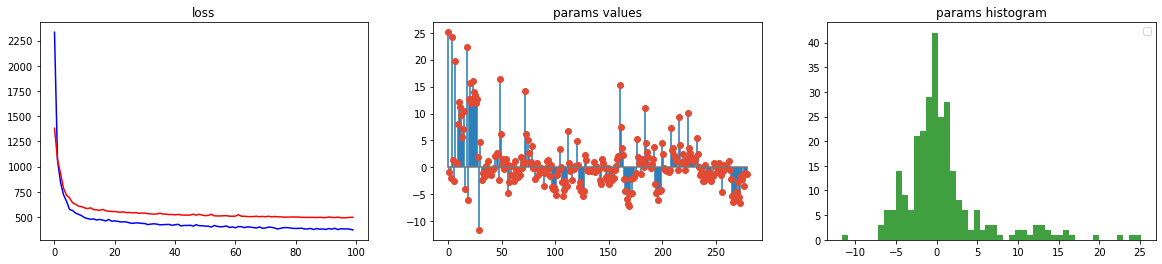

In [ ]:
model.train(batch_size=32)

In [ ]:
class kFoldsCV:
  '''
   Provides train/val indices to split data in train/val sets


  '''
  def __init__(self, n_folds: int=10):
    self.n_folds = n_folds

  def __call__(self,dataset):
    self.train_inputs = dataset.train_inputs
    self.train_targets = dataset.train_targets

    fold_size=len(self.train_inputs)//self.n_folds
    indices=np.arange(len(self.train_inputs))

    fold_indices=[]
    #avg_loss_final=[]

    for i in range(self.n_folds-1):
      fold_indices.append((i*fold_size,(i+1)*fold_size))

    fold_indices.append(((self.n_folds)*fold_size,len(self.train_inputs)))
    fold_losses=[]
    for fold in fold_indices:
      X_val=self.train_inputs[fold[0]:fold[1]]
      Y_val=self.train_targets[fold[0]:fold[1]]
      tr_indices=list(set(indices).difference(set(range(fold[0], fold[1]))))

      X_tr=self.train_inputs[tr_indices]
      Y_tr=self.train_targets[tr_indices]

      fold_dataset=Dataset(path=None)

      fold_dataset.train_inputs=X_tr
      fold_dataset.test_inputs=X_val
      fold_dataset.train_targets=Y_tr
      fold_dataset.test_targets=Y_val

      model=LinearRegressionModel(fold_dataset , lr = 0.001, epochs=100)
      model.train(batch_size=128, plot= True)

      X_val=model.add_one(X_val)
      ypred=model.predict(X_val)

      fold_loss=model.compute_mse_loss(ypred, Y_val)

      fold_losses.append(fold_loss)
      avg_loss=sum(fold_losses)/len(fold_losses)


In [ ]:
cv=kFoldsCV(5)

Epoch: 0 Train - Loss: 21915.7593 Test - Loss: 17818.5730 


No handles with labels found to put in legend.


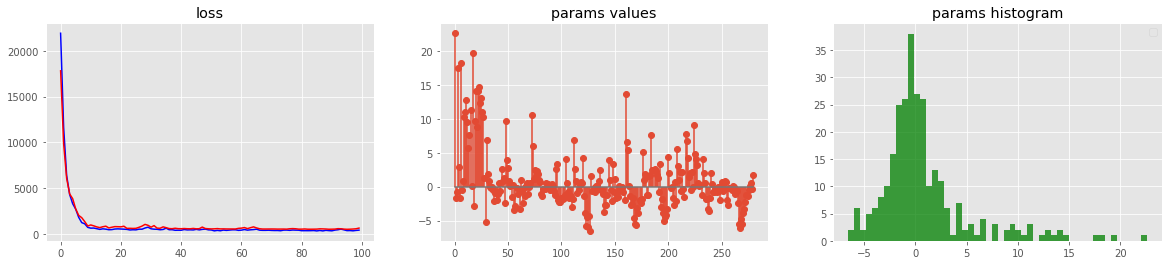

Epoch: 0 Train - Loss: 22353.5889 Test - Loss: 17158.2708 


No handles with labels found to put in legend.


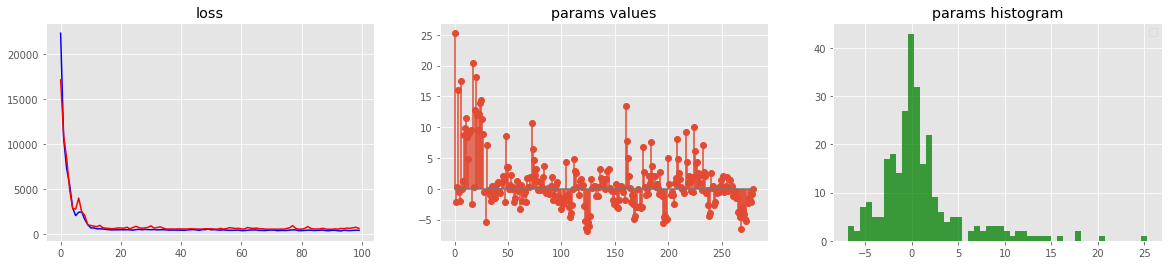

No handles with labels found to put in legend.


Epoch: 0 Train - Loss: 20781.8846 Test - Loss: 17191.5188 


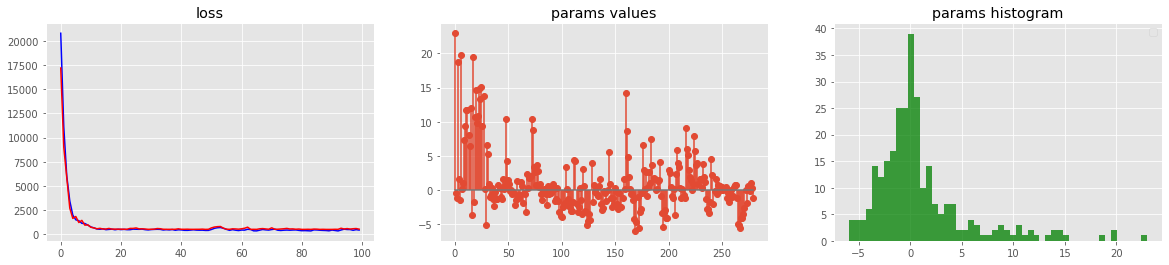

No handles with labels found to put in legend.


Epoch: 0 Train - Loss: 18620.0936 Test - Loss: 15594.5882 


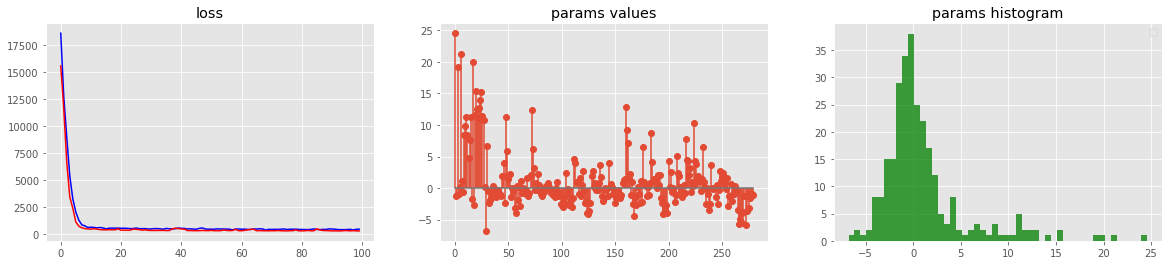

Epoch: 0 Train - Loss: 17205.2384 Test - Loss: 6078.5104 


No handles with labels found to put in legend.


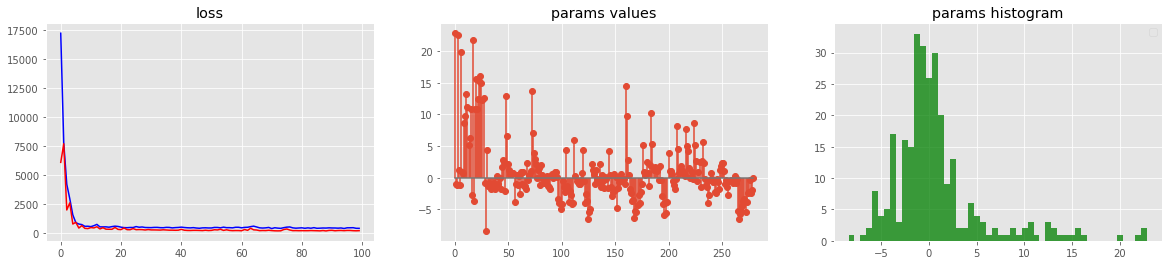

In [ ]:
cv.__call__(dataset)

##L1 Regularization (Lasso Reg):
Lasso stands for Least Absolute **Shrinkage** and **Selection** Operator.

Lasso Regression is useful when some of the features are useless. It will set many of the parameters to zero.

Epoch: 0 Train - Loss: 2154.5818 Test - Loss: 1430.5890 


No handles with labels found to put in legend.


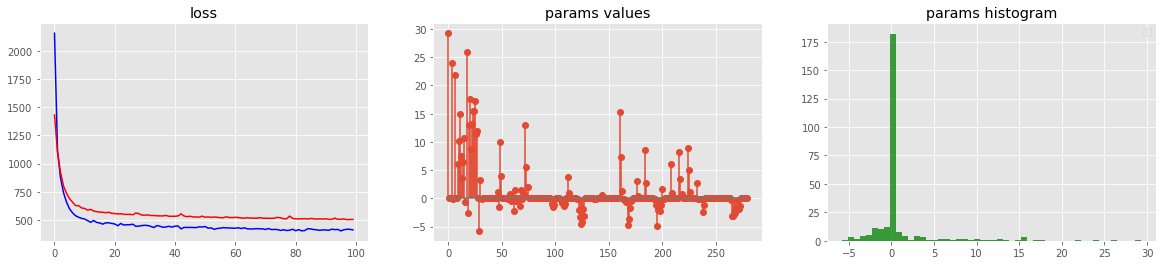

In [ ]:
# The larger your value of l1, the more likely some of the coefficients get closer to zero
model = LinearRegressionModel(dataset, l1=3.5,l2=0.0, lr = 0.001, epochs=100)
model.train(batch_size=32)
#If you look the stem plot we will find that many of the parameters have values ~0

##L2 Regularization (Ridge Reg):

When most of the features are useful, Ridge reg will shrink the parameters but it will not remove them totally.

Epoch: 0 Train - Loss: 2234.7148 Test - Loss: 1406.6131 


No handles with labels found to put in legend.


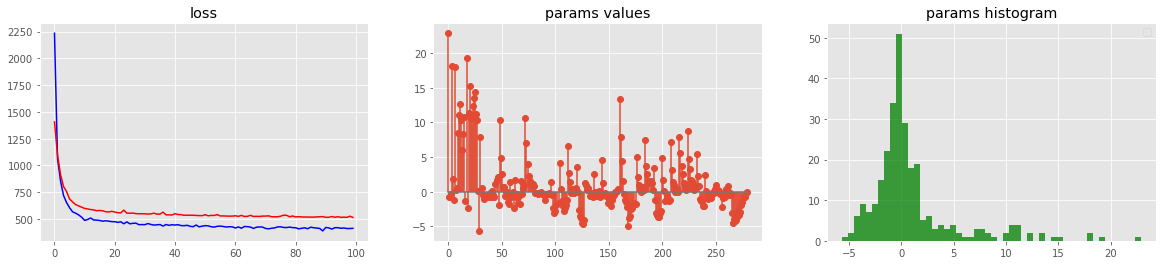

In [ ]:
# The larger your value of l2, the more likely your coefficients get smaller
model = LinearRegressionModel(dataset, l2=0.4, l1=0.0, lr=0.001, epochs=100)
model.train(batch_size=32)

## Elastic Net

Elastic net combines both ridge reg and lasso reg

Epoch: 0 Train - Loss: 2404.5718 Test - Loss: 1441.3504 


No handles with labels found to put in legend.


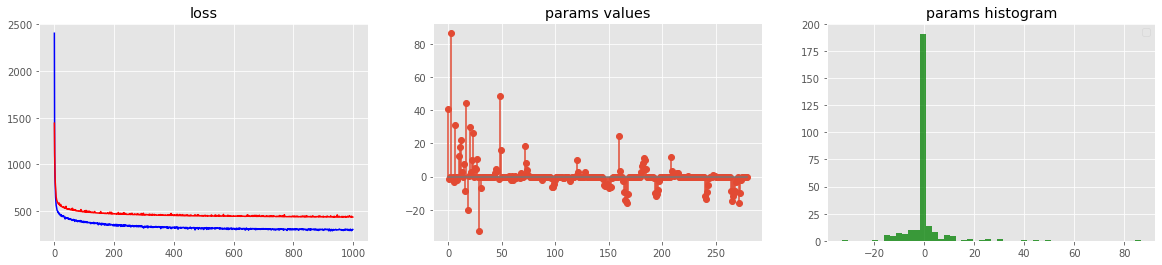

In [ ]:
# The larger your value of l2, the more likely your coefficients get smaller
model = LinearRegressionModel(dataset, l2=0.2, l1=0.8, lr=0.001, epochs=1000)
model.train(batch_size=32)